In [1]:
import torch
import matplotlib.pyplot as plt

In [5]:
"""
此单元格是bevfusion中初始化视锥的源码
"""
def create_frustum(image_size, feature_size, dbound):
    iH, iW = image_size
    fH, fW = feature_size

    # ds代表depth stride。是深度方向的步长。这里是1~118
    ds = (
        torch.arange(*dbound, dtype=torch.float)
        .view(-1, 1, 1)
        .expand(-1, fH, fW) # 118， 32， 88
    )
    D, _, _ = ds.shape

    # xs代表x stride。是x方向的步长。这里是0到703,等值取88个点
    xs = (
        torch.linspace(0, iW - 1, fW, dtype=torch.float)
        .view(1, 1, fW)
        .expand(D, fH, fW)
    )
    
    # ys代表Y stride。是y方向的步长。这里是0到31,等值取32个点
    ys = (
        torch.linspace(0, iH - 1, fH, dtype=torch.float)
        .view(1, fH, 1)
        .expand(D, fH, fW)
    )

    frustum = torch.stack((xs, ys, ds), -1)
    return frustum

if __name__ == "__main__":
    image_size = 256, 704  # H , W
    feature_size = 32, 88   # H , W
    dbound = [1.0, 60.0, 0.5]
    res = create_frustum(image_size, feature_size, dbound)
    print(res.shape)

torch.Size([118, 32, 88, 3])


/usr/local/lib/python3.8/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


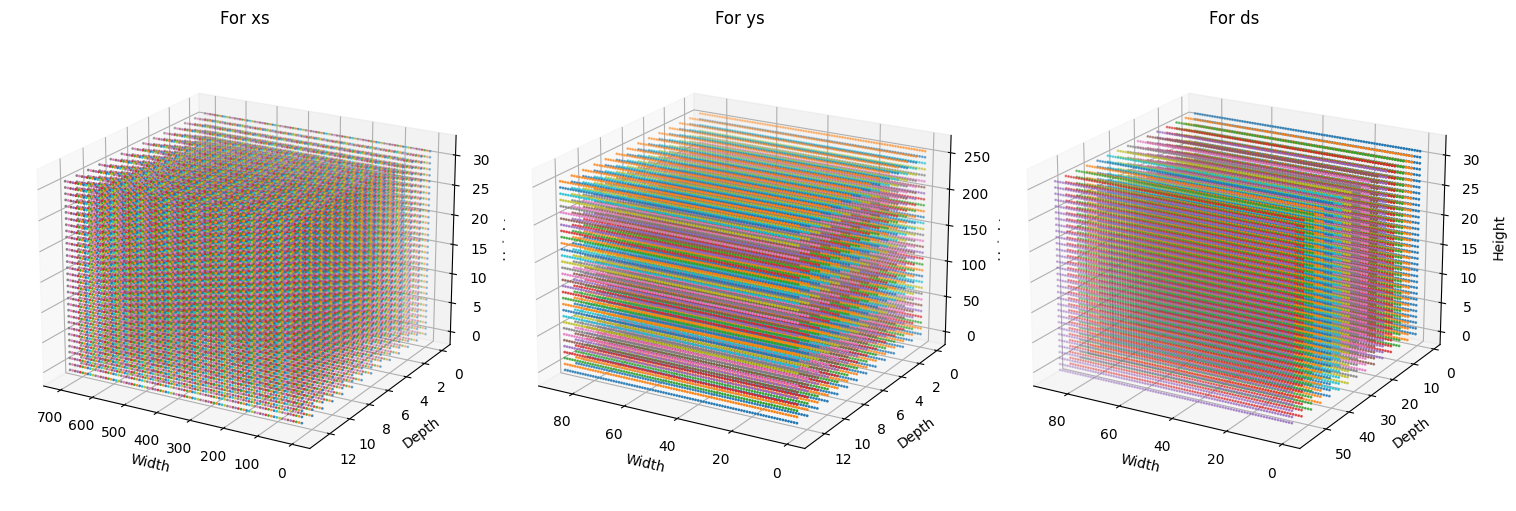

In [3]:
image_size = (256, 704)  # H , W
feature_size = (32, 88)  # H , W
dbound = [1.0, 60.0, 4]

iH, iW = image_size
fH, fW = feature_size

D = int((dbound[1] - dbound[0]) / dbound[2])

# For ys:
ys = (
    torch.linspace(0, iH - 1, fH, dtype=torch.float) # iH 256  fH 32 从0-255 采样32个点
    .view(1, fH, 1)
    .expand(D, fH, fW) # 【118， 32， 88】
)

# For xs:
xs = (
    torch.linspace(0, iW - 1, fW, dtype=torch.float) # iW 704  fW 88 从0-703 采样88个点
    .view(1, 1, fW) 
    .expand(D, fH, fW) # 【118， 32， 88】
)

# For ds:
ds = (
    torch.arange(*dbound, dtype=torch.float)
    .view(-1, 1, 1)
    .expand(-1, fH, fW) # 118， 32， 88
)

# ... [前面的代码保持不变]

# Plotting:
fig = plt.figure(figsize=(15, 5))

# Plot for xs:
ax1 = fig.add_subplot(131, projection='3d')
y, z = torch.meshgrid(torch.arange(fH), torch.arange(D))
for width in range(xs.shape[2]):
    ax1.scatter(xs[:,:,width].numpy().flatten(), z.numpy().flatten(), y.numpy().flatten(), s=1)
ax1.set_title('For xs')
ax1.set_xlabel('Width')
ax1.set_ylabel('Depth')
ax1.set_zlabel('Height')
ax1.view_init(elev=20., azim=120)

# Plot for ys:
ax2 = fig.add_subplot(132, projection='3d')
x, z = torch.meshgrid(torch.arange(fW), torch.arange(D)) # 注意这里改为x, z
for height in range(ys.shape[1]):
    ax2.scatter(x.numpy().flatten(), z.numpy().flatten(), ys[:,height,:].numpy().flatten(), s=1)
ax2.set_title('For ys')
ax2.set_xlabel('Width')
ax2.set_ylabel('Depth')
ax2.set_zlabel('Height')
ax2.view_init(elev=20., azim=120)

# Plot for ds:
ax3 = fig.add_subplot(133, projection='3d')
x, y = torch.meshgrid(torch.arange(fW), torch.arange(fH))
for depth in range(ds.shape[0]):
    ax3.scatter(x.numpy().flatten(), ds[depth,:,:].numpy().flatten(), y.numpy().flatten(), s=1)
ax3.set_title('For ds')
ax3.set_xlabel('Width')
ax3.set_ylabel('Depth')
ax3.set_zlabel('Height')
ax3.view_init(elev=20., azim=120)

plt.tight_layout()
plt.show()

In [1]:
import torch
import matplotlib.pyplot as plt


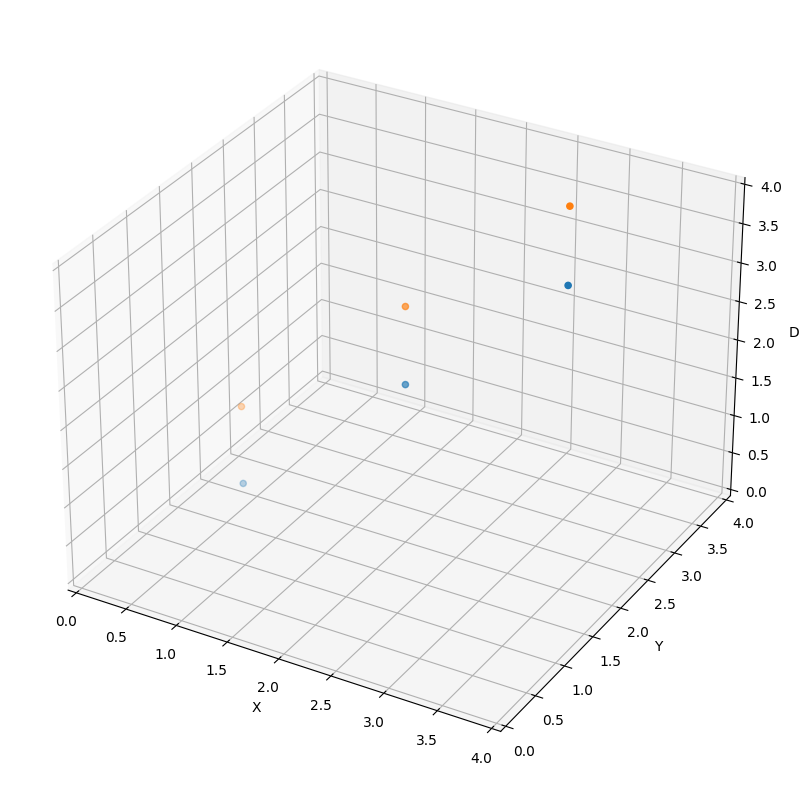

In [2]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection='3d')

ax.set_xlim([0, 4])
ax.set_ylim([0, 4])
ax.set_zlim([0, 4])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('D')

x = [1, 2, 3]
y = [1, 2, 3]
d = [1, 2, 3]
ax.scatter(x, y, d, marker="o")

x2 = [1, 2, 3]
y2 = [1, 2, 3]
d2 = [2, 3, 4]
ax.scatter(x2, y2, d2, marker="o")

plt.show()


In [6]:
image_size = 256, 704  # H , W
feature_size = 32, 88   # H , W
dbound = [1.0, 60.0, 0.5]
points = create_frustum(image_size, feature_size, dbound)
print(points.shape)

torch.Size([118, 32, 88, 3])


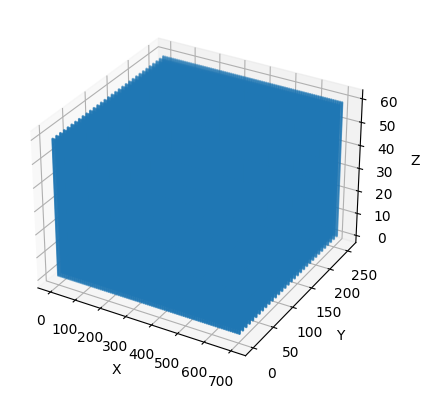

In [8]:
frustum = points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(frustum[:, :, :, 0], frustum[:, :, :, 1], frustum[:, :, :, 2], s=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [37]:
print(points[0, 0, 0])
print(points[1, 0, 0])
print(points[0, 1, 0])
print(points[0, 0, 1])
print()
"""
可以理解为将以摄像机为原点的坐标系里。
实际d=1米处，与d=118米处以0.5为步长。划分为118个区间
实际x=-54米处，与d=118米处以0.5为步长。划分为118个区间
"""
print(points[0, 0, 0]) 
print(points[1, 0, 0])
print(points[2, 0, 0])
print(points[117, 0, 0])

print()
print(points[0, 0, 0])
print(points[0, 1, 0])
print(points[0, 2, 0])
print(points[0, 31, 0])
print()
print(points[0, 0, 0])
print(points[0, 0, 1])
print(points[0, 0, 2])
print(points[0, 0, 97])


tensor([0., 0., 1.])
tensor([0.0000, 0.0000, 1.5000])
tensor([0.0000, 8.2258, 1.0000])
tensor([8.0805, 0.0000, 1.0000])

tensor([0., 0., 1.])
tensor([0.0000, 0.0000, 1.5000])
tensor([0., 0., 2.])
tensor([ 0.0000,  0.0000, 59.5000])

tensor([0., 0., 1.])
tensor([0.0000, 8.2258, 1.0000])
tensor([ 0.0000, 16.4516,  1.0000])
tensor([  0., 255.,   1.])

tensor([0., 0., 1.])
tensor([8.0805, 0.0000, 1.0000])
tensor([16.1609,  0.0000,  1.0000])


IndexError: index 97 is out of bounds for dimension 2 with size 88

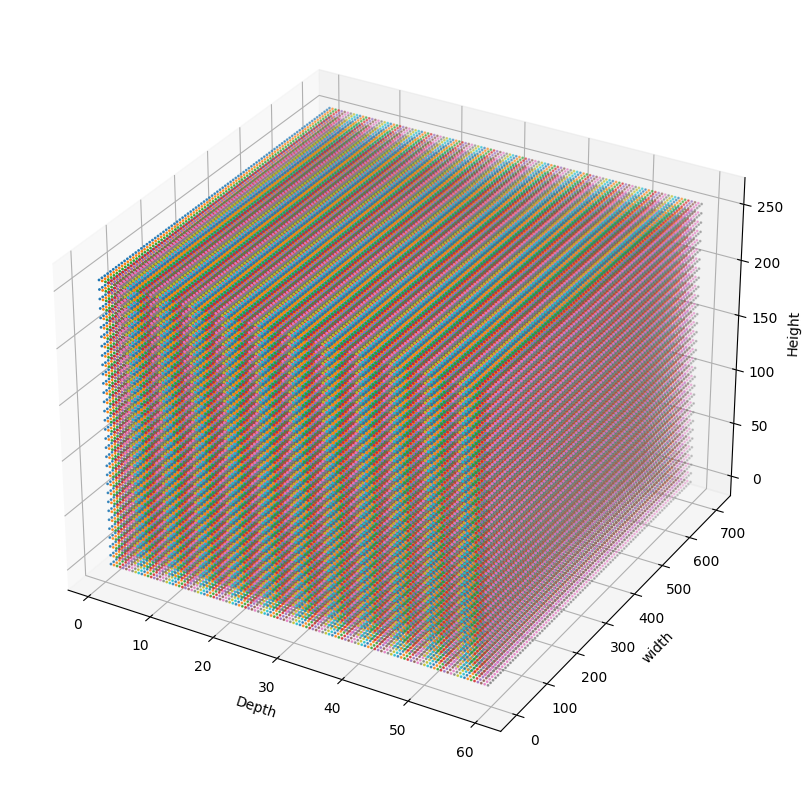

In [31]:
"""
首先理解xs ys  ds的含义
"""
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel('Depth')
ax.set_ylabel('width')
ax.set_zlabel('Height')

D, H, W, coor = points.shape
for d_index in range(D):
    points_dIdx = points[d_index]
    points_dIdx = points_dIdx.reshape(-1, 3)
    
    # print(points_dIdx.shape) # torch.Size([2816, 3])
    x, y, d = points_dIdx.T
    
    # print(min(x))
    # print(max(x))
    # print(min(y))
    # print(max(y))
    # print(min(d))
    # print(max(d))
    
    ax.scatter(d, x, y, marker="o", s=1) 
plt.show()
    
    